In [1]:
import cv2
import numpy as np
import os
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float
from skimage import io
from matplotlib import pyplot as plt
import matplotlib.path as mplPath
import xml.etree.ElementTree as ET

In [2]:
def plotImage(img, size):
    fig, ax = plt.subplots(figsize=(size,size))
    plt.imshow(img)
    plt.xticks([]),plt.yticks([])
    plt.show()

In [3]:
def subplot(titles, images, rows, imgPerRows, size):
    fig, ax = plt.subplots(figsize=(size,size))
    for i in range(len(images)):
        plt.subplot(rows,imgPerRows,i+1),plt.imshow(images[i])
        plt.title(titles[i])
        plt.xticks([]),plt.yticks([])
    plt.show()

In [4]:
def resizeImage (image):
    factor = 2**-3
    dim = (int(image.shape[1]*factor),int(image.shape[0]*factor))
    resized = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)
    return resized

In [5]:
def generateCNNInputs(imgList, inputList, numSuperPixels, sizePatch):
    for i in range(len(imgList)):
        img = imgList[i]
        imgCopy = img.copy()
        segments = slic(img,numSuperPixels)
        
        for (j , segVal) in enumerate(np.unique(segments)):

            if segVal == 0:
                continue

            mask = np.zeros(img.shape[:2], dtype = "uint8")
            mask[segments == segVal] = 255
            # detect contours in the mask and grab the largest one
            cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[-2]
            c = max(cnts, key=cv2.contourArea)
            #saving every single cell as a rectangular image.
            x,y,w,h = cv2.boundingRect(c)
            roi = image[y:y+h, x:x+w]
            xPatch = 0
            yPatch = 0
            
            if roi.shape[0]*roi.shape[1] < sizePatch**2:
                xPatch = x-sizePach/2+w/2
                yPatch = y-siezePatch/2+h/2
            else:
                xPatch = x+sizePach/2-w/2
                yPatch = y+siezePatch/2-h/2
            
            patch = image[yPatch:y+sizePatch, xPatch:x+sizePatch]
            patchGray = cv2.cvtColor(patch, cv2.COLOR_BGR2GRAY)
            inputList.append(patchGray)
            

In [6]:
def groundThruthFindCountourPointsByRegion (pathGroundThruthFile, region) :
    listPixels = []
    polygonsByRegion = []
    pointsPolygon = []
    tree = ET.parse(pathGroundThruthFile)
    root = tree.getroot()

    for neighbor in root.iter('TextRegion') :
        
        if (neighbor.attrib['type'] == region) :
            pointsPolygon = []
            
            for coord in neighbor.findall('Coords') :
                
                for point in coord.findall('Point') :
                    pointsPolygon.append([point.attrib['x'], point.attrib['y']])
                    
                polygonsByRegion.append(pointsPolygon)
                
    return polygonsByRegion

In [7]:
def isInsidePolygon (listPointsPolygon, x, y) :
    bbPath = mplPath.Path(listPointsPolygon)
    point = ([x, y])
    return bbPath.contains_point(point)

In [8]:
def paintPolygon (listPointPolygonRegion, listPointsInsidePolygon, image, factor, B, G, R) :
    imageWidth = image.shape[1] #Get image width
    imageHeight = image.shape[0] #Get image height
    xPos, yPos = 0, 0
    while xPos < imageWidth: #Loop through rows
        while yPos < imageHeight: #Loop through collumns
            if isInsidePolygon (listPointPolygonRegion, xPos*factor, yPos*factor) :
                image.itemset((yPos, xPos, 0), B)
                image.itemset((yPos, xPos, 1), G)
                image.itemset((yPos, xPos, 2), R)
                listPointsInsidePolygon.append([xPos,yPos])
            yPos = yPos + 1 #Increment Y position by 1

        yPos = 0
        xPos = xPos + 1 #Increment X position by 1    

In [9]:
def paintPointsOutsideList (listPoints, image, B, G, R) :
    imageWidth = image.shape[1] #Get image width
    imageHeight = image.shape[0] #Get image height
    #from IPython.core.debugger import Tracer; Tracer()() 
    xPos, yPos = 0, 0
    for i in range(len(listPoints)) :
        point = listPoints[i]
        x = point[0]
        y = point[1]
        while xPos < imageWidth: #Loop through rows
            while yPos < imageHeight: #Loop through collumns
                if xPos == x and yPos == y :
                    image.itemset((yPos, xPos, 0), B)
                    image.itemset((yPos, xPos, 1), G)
                    image.itemset((yPos, xPos, 2), R)

                yPos = yPos + 1 #Increment Y position by 1

            yPos = 0
            xPos = xPos + 1 #Increment X position by 1       

In [10]:
path = 'groundTruth/d-006_kai.chen@unifr.ch.xml'
#listPoints = groundThruthFindCountourPointsByRegion (path, 'decoration')
#boolean = isInsidePolygon (listPoints, 1123, 936)
#print (boolean)

In [11]:
nameFolder = 'parzivalDataset'
ximg_train = []
ximg_test = []
ximg_va = []
ximg = []
imgOrigs = []

x_train = []
y_train = []
x_test = []
y_test = []
x_va = []
y_va = []
x = []
y = []


In [12]:
for file in os.listdir(nameFolder):
    image = cv2.imread(nameFolder + "/" + file)
    imageResized = resizeImage(image)
    imgOrigs.append(image)
    ximg.append(imageResized)


In [13]:
ximg_train = ximg[:37]
ximg_test = ximg[37:]

print(np.shape(ximg_train))
print(np.shape(ximg_test))

(37, 376, 250, 3)
(10, 376, 250, 3)


In [14]:
imgTr = ximg_train[0]
imgTrainCopy = imgTr.copy()


### Printing ground thruth segments on image: 
### Peripheric(outside page), Background(page), text block(text) ,decoration and comment

In [15]:
imgTr
imageWidth = imgTr.shape[1] #Get image width
imageHeight = imgTr.shape[0] #Get image height
print (imageWidth)
print (imageHeight)

250
376


In [16]:
path = 'groundTruth/d-006_kai.chen@unifr.ch.xml'
regions = ['page','text','decoration','comment','periphery']
listTotalPointsContainedInRegions = []

for k in range(len(regions)) :
    listPolygons = groundThruthFindCountourPointsByRegion(path,regions[k])
    for t in range(len(listPolygons)) :
        listPointPolygonRegion = listPolygons[t]
        
        if (regions[k] == 'decoration') :
            paintPolygon(listPointPolygonRegion, listTotalPointsContainedInRegions, imgTr, 2**3, 0, 0, 255)
        elif (regions[k] == 'text') : 
            paintPolygon(listPointPolygonRegion, listTotalPointsContainedInRegions, imgTr, 2**3, 0, 255, 0)
        elif (regions[k] == 'comment') : 
            paintPolygon(listPointPolygonRegion, listTotalPointsContainedInRegions, imgTr, 2**3, 255, 0, 0) 
        elif (regions[k] == 'page') : 
            paintPolygon(listPointPolygonRegion, listTotalPointsContainedInRegions, imgTr, 2**3, 255, 255, 255)
            
    #paintPointsOutsideList(listTotalPointsContainedInRegions, imgTr, 255, 0, 0)

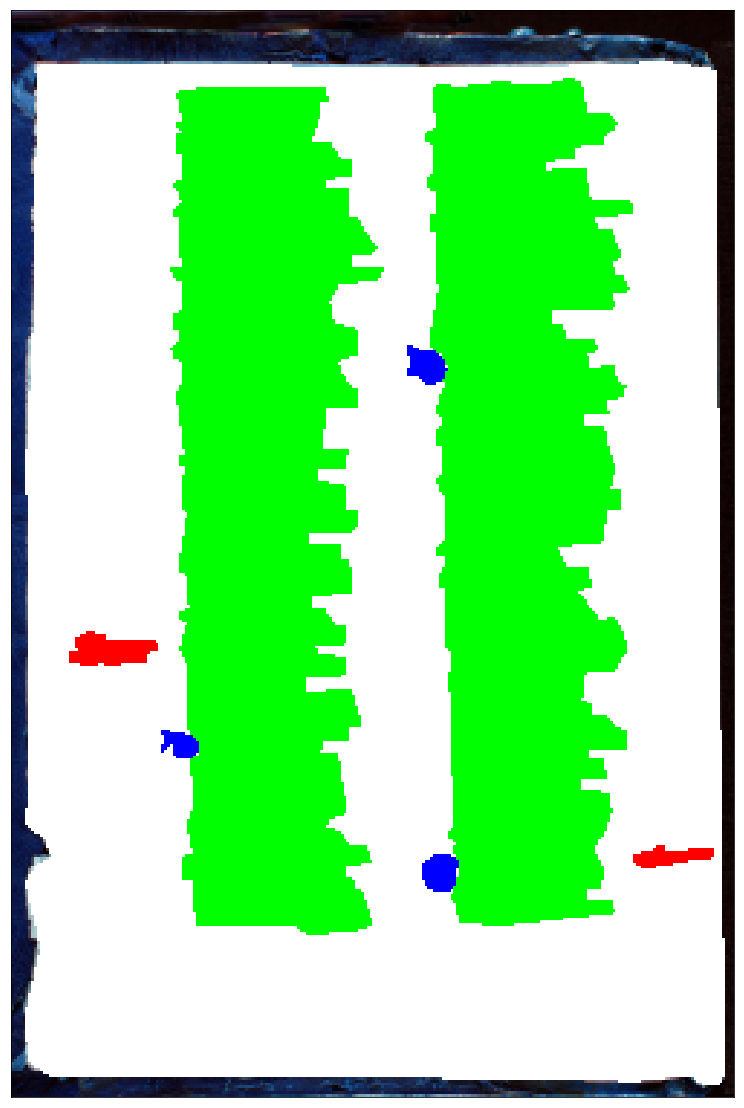

In [17]:
plotImage (imgTr,20)